# Evolutionary Algorithms

Evolutionary Algorithm hyperparameter tuner

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import sys
import matplotlib
libraries = (('Matplotlib', matplotlib), ('Numpy', np))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1


In [3]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

X = load_boston().data
y = load_boston().target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

For the genome sequence we'll allow for many of the parameters in MLPClassifier. The format will be:

```bash
[layer 0 nodes, layer 1 nodes, ... , layer 4 nodes, activation, solver, alpha, learning_rate, learning_rate_init, max_iter]. 
```

For breeding, we'll use the two parents and randomly select from each parent a gene.

In [4]:
np.random.seed(42)
def create_guess(layer_max=10):
    genome = [np.random.randint(1,layer_max)] # first layer must have at least one node
    # layer sizes
    for _ in range(4):
        genome.append(np.random.randint(1,layer_max))
    # Activation functions
    genome.append(np.random.choice(['identity', 'logistic', 'tanh', 'relu']))
    # Solver
    genome.append(np.random.choice(['lbfgs','sgd','adam']))
    # Alpha (L2 penalty)
    genome.append(np.random.uniform(1e-6,1))
    # Learning Rate
    genome.append(np.random.choice(['constant', 'invscaling', 'adaptive']))
    genome.append(np.random.uniform(1e-6,1))
    # max iter
    genome.append(np.random.randint(1,500))
    return genome

create_guess()

[7,
 4,
 8,
 5,
 7,
 'logistic',
 'adam',
 0.09997581584308707,
 'adaptive',
 0.8661762795987894,
 100]

In [5]:
def create_generation(population=100, layer_max=10):
    generation = [create_guess(layer_max) for _ in range(population)]
    return generation

test_generation = create_generation(population=10)
print(test_generation)

[[8, 8, 3, 6, 5, 'logistic', 'sgd', 0.21233989833916547, 'constant', 0.617481892146207, 314], [6, 9, 1, 3, 7, 'relu', 'lbfgs', 0.046451366269585, 'adaptive', 0.6803078582802411, 329], [7, 2, 4, 9, 2, 'logistic', 'lbfgs', 0.015967236253961976, 'invscaling', 0.6842333422791304, 367], [7, 8, 3, 1, 4, 'logistic', 'sgd', 0.42515644933537017, 'invscaling', 0.5467107326330003, 310], [2, 2, 4, 8, 7, 'relu', 'lbfgs', 0.9611720631773247, 'constant', 0.3886779010121923, 338], [5, 8, 9, 9, 1, 'identity', 'adam', 0.4234020573048889, 'constant', 0.19871648281849086, 472], [3, 1, 8, 3, 3, 'identity', 'adam', 0.07404557768943863, 'adaptive', 0.651077374424919, 28], [7, 9, 8, 2, 1, 'relu', 'adam', 0.31098301073334045, 'constant', 0.7296064487318857, 360], [6, 3, 1, 3, 5, 'tanh', 'sgd', 0.8489139753522597, 'constant', 0.5612776362922987, 255], [7, 9, 3, 7, 1, 'relu', 'lbfgs', 0.5085711825940116, 'invscaling', 0.1393323150744213, 231]]


Now we need a function to define how "good" these guesses are, because we want to strongest to surive. In this case, we'll just make a simple function that scores them on how many of the characters are in the correct position. In evolutionary algorithm parlance, this is called a fitness function.

In [36]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

num_layers = 5

def get_model(guess):
    layers = tuple(guess[:num_layers])
    mlp = MLPRegressor(hidden_layer_sizes=layers, activation=guess[num_layers], solver=guess[num_layers+1], 
                       alpha=guess[num_layers+2], learning_rate=guess[num_layers+3], 
                       learning_rate_init=guess[num_layers+4], max_iter=guess[num_layers+5], random_state=42)
    return mlp

def fitness_score(guess):
    """
    We'll build the model, then train it and test it.
    """
    mlp = get_model(guess)
    mlp.fit(X_train, y_train)
    pred = mlp.predict(X_test)
    del mlp
    return np.mean((y_test - pred)**2)

def check_fitness(guesses):
    """
    Goes through every guess and calculates the fitness score. 
    Returns a list of tuples: (guess, fitness_score)
    """
    fitness_indicator = []
    for guess in guesses:
        fitness_indicator.append((guess, fitness_score(guess)))
    return fitness_indicator

print(check_fitness(test_generation))

[([8, 8, 3, 6, 5, 'logistic', 'sgd', 0.21233989833916547, 'constant', 0.617481892146207, 314], 221053.10965236061), ([6, 9, 1, 3, 7, 'relu', 'lbfgs', 0.046451366269585, 'adaptive', 0.6803078582802411, 329], 74.965188115807081), ([7, 2, 4, 9, 2, 'logistic', 'lbfgs', 0.015967236253961976, 'invscaling', 0.6842333422791304, 367], 62.302919283214067), ([7, 8, 3, 1, 4, 'logistic', 'sgd', 0.42515644933537017, 'invscaling', 0.5467107326330003, 310], 459.5208337220937), ([2, 2, 4, 8, 7, 'relu', 'lbfgs', 0.9611720631773247, 'constant', 0.3886779010121923, 338], 23.296281107637249), ([5, 8, 9, 9, 1, 'identity', 'adam', 0.4234020573048889, 'constant', 0.19871648281849086, 472], 57579.077152610145), ([3, 1, 8, 3, 3, 'identity', 'adam', 0.07404557768943863, 'adaptive', 0.651077374424919, 28], 264341.78970529709), ([7, 9, 8, 2, 1, 'relu', 'adam', 0.31098301073334045, 'constant', 0.7296064487318857, 360], 521.65185093163711), ([6, 3, 1, 3, 5, 'tanh', 'sgd', 0.8489139753522597, 'constant', 0.5612776362

In [8]:
def get_breeders_from_generation(guesses, take_best_N=10, take_random_N=5, verbose=False, mutation_rate=0.1):
    """
    This sets up the breeding group for the next generation. You have
    to be very careful how many breeders you take, otherwise your
    population can explode. These two, plus the "number of children per couple"
    in the make_children function must be tuned to avoid exponential growth or decline!
    """
    # First, get the top guesses from last time
    fit_scores = check_fitness(guesses)
    sorted_guesses = sorted(fit_scores, key=lambda x: x[1])
    new_generation = [x[0] for x in sorted_guesses[:take_best_N]]
    best_guess = new_generation[0]
    
    if verbose:
        # If we want to see what the best current guess is!
        print(best_guess)
    
    # Second, get some random ones for genetic diversity
    for _ in range(take_random_N):
        new_generation.append(guesses[np.random.randint(len(guesses))])
    
    np.random.shuffle(new_generation)
    return new_generation, best_guess

def make_child(parent1, parent2):
    """ 
    Randomly select parent 1 or parent 2 for each character and give
    the child the "gene" from that parent.
    """
    child = list(parent1)
    parent2 = list(parent2)
    for ix, gene in enumerate(child):
        if np.random.uniform() >= 0.5:
            child[ix] = parent2[ix]
    return child

def make_children(old_generation, children_per_couple=1):
    """
    Pairs parents together, and makes children for each pair. 
    If there are an odd number of parent possibilities, one 
    will be left out. 
    
    Pairing happens by pairing the first and last entries. 
    Then the second and second from last, and so on.
    """
    mid_point = len(old_generation)//2
    next_generation = [] 
    
    for ix, parent in enumerate(old_generation[:mid_point]):
        for _ in range(children_per_couple):
            next_generation.append(make_child(parent, old_generation[-ix-1]))
    return next_generation

In [9]:
make_child([8, 8, 3, 6, 5, 'logistic', 'sgd', 0.21233989833916547, 'constant', 0.617481892146207, 314],
           [6, 9, 1, 3, 7, 'relu', 'lbfgs', 0.046451366269585, 'adaptive', 0.6803078582802411, 329])

[6,
 9,
 3,
 6,
 7,
 'relu',
 'lbfgs',
 0.21233989833916547,
 'constant',
 0.617481892146207,
 314]

Let's look at a test cycle with our test_generation.

In [10]:
breeders, _ = get_breeders_from_generation(test_generation)
print(breeders)

[[3, 1, 8, 3, 3, 'identity', 'adam', 0.07404557768943863, 'adaptive', 0.651077374424919, 28], [7, 8, 3, 1, 4, 'logistic', 'sgd', 0.42515644933537017, 'invscaling', 0.5467107326330003, 310], [8, 8, 3, 6, 5, 'logistic', 'sgd', 0.21233989833916547, 'constant', 0.617481892146207, 314], [6, 9, 1, 3, 7, 'relu', 'lbfgs', 0.046451366269585, 'adaptive', 0.6803078582802411, 329], [6, 3, 1, 3, 5, 'tanh', 'sgd', 0.8489139753522597, 'constant', 0.5612776362922987, 255], [7, 9, 3, 7, 1, 'relu', 'lbfgs', 0.5085711825940116, 'invscaling', 0.1393323150744213, 231], [7, 2, 4, 9, 2, 'logistic', 'lbfgs', 0.015967236253961976, 'invscaling', 0.6842333422791304, 367], [5, 8, 9, 9, 1, 'identity', 'adam', 0.4234020573048889, 'constant', 0.19871648281849086, 472], [3, 1, 8, 3, 3, 'identity', 'adam', 0.07404557768943863, 'adaptive', 0.651077374424919, 28], [7, 2, 4, 9, 2, 'logistic', 'lbfgs', 0.015967236253961976, 'invscaling', 0.6842333422791304, 367], [7, 9, 8, 2, 1, 'relu', 'adam', 0.31098301073334045, 'const

In [11]:
print(make_children(breeders, children_per_couple=2))

[[6, 1, 8, 3, 5, 'tanh', 'adam', 0.8489139753522597, 'constant', 0.651077374424919, 28], [3, 1, 8, 3, 3, 'tanh', 'sgd', 0.8489139753522597, 'constant', 0.651077374424919, 28], [7, 8, 3, 1, 4, 'logistic', 'sgd', 0.42515644933537017, 'invscaling', 0.5467107326330003, 310], [7, 8, 3, 1, 4, 'logistic', 'sgd', 0.42515644933537017, 'invscaling', 0.5467107326330003, 310], [8, 8, 3, 6, 7, 'relu', 'sgd', 0.21233989833916547, 'constant', 0.617481892146207, 338], [2, 8, 4, 6, 5, 'relu', 'sgd', 0.21233989833916547, 'constant', 0.617481892146207, 314], [6, 9, 8, 3, 7, 'relu', 'adam', 0.046451366269585, 'adaptive', 0.6803078582802411, 28], [6, 9, 8, 3, 3, 'relu', 'lbfgs', 0.07404557768943863, 'adaptive', 0.651077374424919, 28], [6, 3, 8, 2, 1, 'relu', 'adam', 0.31098301073334045, 'constant', 0.7296064487318857, 255], [7, 9, 1, 2, 5, 'relu', 'adam', 0.31098301073334045, 'constant', 0.5612776362922987, 255], [7, 9, 4, 7, 2, 'relu', 'lbfgs', 0.015967236253961976, 'invscaling', 0.6842333422791304, 367],

Sweet, it looks like our parents features are being carried on, but aren't being directly copies. So all is going how we hoped for now. Now let's try actually solving the problem by letting many generations happen and turning up how many guesses there are in the initial generation. We'll also change the password here to something easier to tell whether the algorithm is working.

Let's put this into a function so we can repeat it with different sets of stuff.

In [41]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

def check_equal(fitness_list, num_to_check=5):
    last = fitness_list[-1]
    for el in fitness_list[-num_to_check:-1]:
        if el != last:
            return False
    return True

def evolve_to_solve(current_generation, max_generations, take_best_N, take_random_N,
                    mutation_rate, children_per_couple, print_every_n_generations, verbose=False):
    fitness_tracking = []
    is_verbose=verbose
    for i in range(max_generations):
        breeders, best_guess = get_breeders_from_generation(current_generation,
                                                            take_best_N=take_best_N, take_random_N=take_random_N, 
                                                            verbose=is_verbose, mutation_rate=mutation_rate)
        fitness_tracking.append(fitness_score(best_guess))
        if verbose and not i % print_every_n_generations and i > 0:
            print("Generation %i: "%i, end='')
            print(len(current_generation))
            print("Current Best Score: ", fitness_tracking[-1])
            is_verbose = True
        else:
            is_verbose = False
        # If the last 5 generations all had the same fitness level
        # go ahead and call it converged
        if len(fitness_tracking) > 5:
            if check_equal(fitness_tracking, num_to_check=5):
                break
                
        current_generation = make_children(breeders, children_per_couple=children_per_couple)
    return fitness_tracking, best_guess

current_generation = create_generation(population=50)
fitness_tracking, best_guess = evolve_to_solve(current_generation, 30, 25, 5, 0.5, 4, 1, verbose=True)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_base.py:194: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2


[6, 5, 2, 7, 9, 'identity', 'sgd', 0.4993402354303896, 'adaptive', 0.8622579127414635, 440]
Generation 1: 60
Current Best Score:  27.165802517
[8, 5, 2, 7, 6, 'relu', 'lbfgs', 0.635781102934438, 'constant', 0.2775090289370536, 308]
Generation 2: 60
Current Best Score:  25.3929566292
[8, 5, 8, 3, 2, 'relu', 'lbfgs', 0.2577781423925341, 'adaptive', 0.02135677530502755, 414]
Generation 3: 60
Current Best Score:  19.9723004657
[2, 5, 8, 4, 9, 'relu', 'lbfgs', 0.9174486218280408, 'constant', 0.02135677530502755, 414]
Generation 4: 60
Current Best Score:  18.430959048
[5, 6, 2, 8, 2, 'relu', 'lbfgs', 0.4532797258923909, 'adaptive', 0.3973993222946642, 440]
Generation 5: 60
Current Best Score:  20.9900835124
[6, 6, 2, 7, 6, 'relu', 'lbfgs', 0.9202592465505826, 'constant', 0.3973993222946642, 355]
Generation 6: 60
Current Best Score:  19.7267508137
[2, 5, 8, 7, 9, 'relu', 'lbfgs', 0.9202592465505826, 'constant', 0.02135677530502755, 308]
Generation 7: 60
Current Best Score:  18.4969658579
[8, 

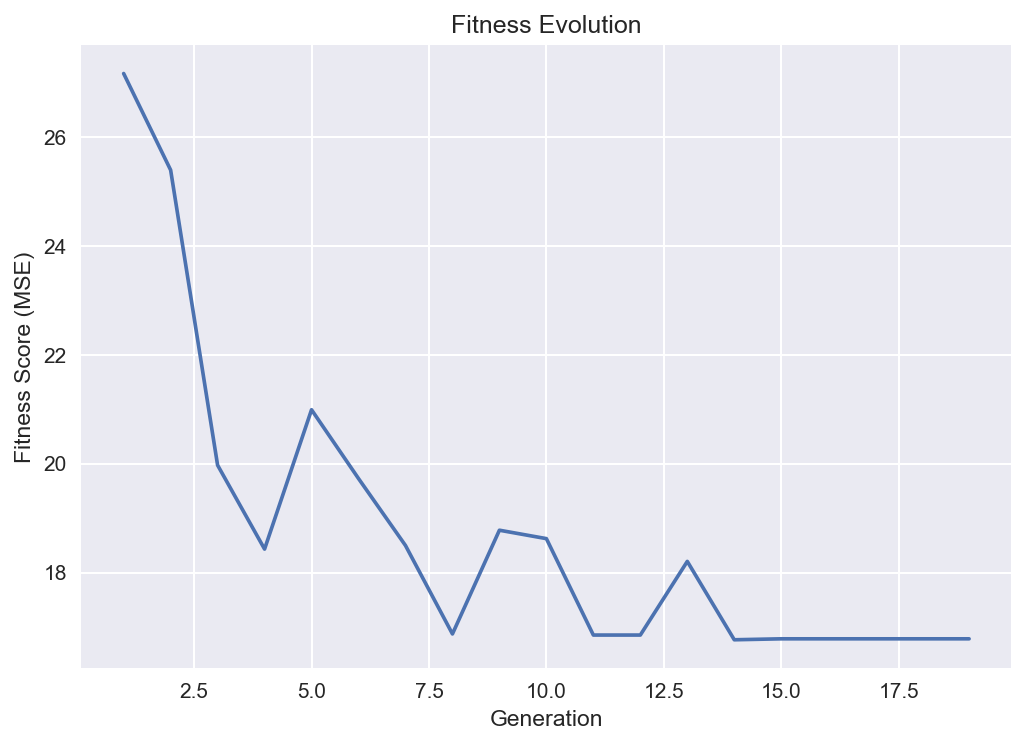

In [42]:
def make_fitness_tracking_plot(fitness_tracking):
    plt.figure(dpi=150)
    plt.plot(range(len(fitness_tracking)), fitness_tracking)
    plt.ylabel("Fitness Score (MSE)")
    plt.xlabel("Generation")
    plt.title("Fitness Evolution");

make_fitness_tracking_plot(fitness_tracking)

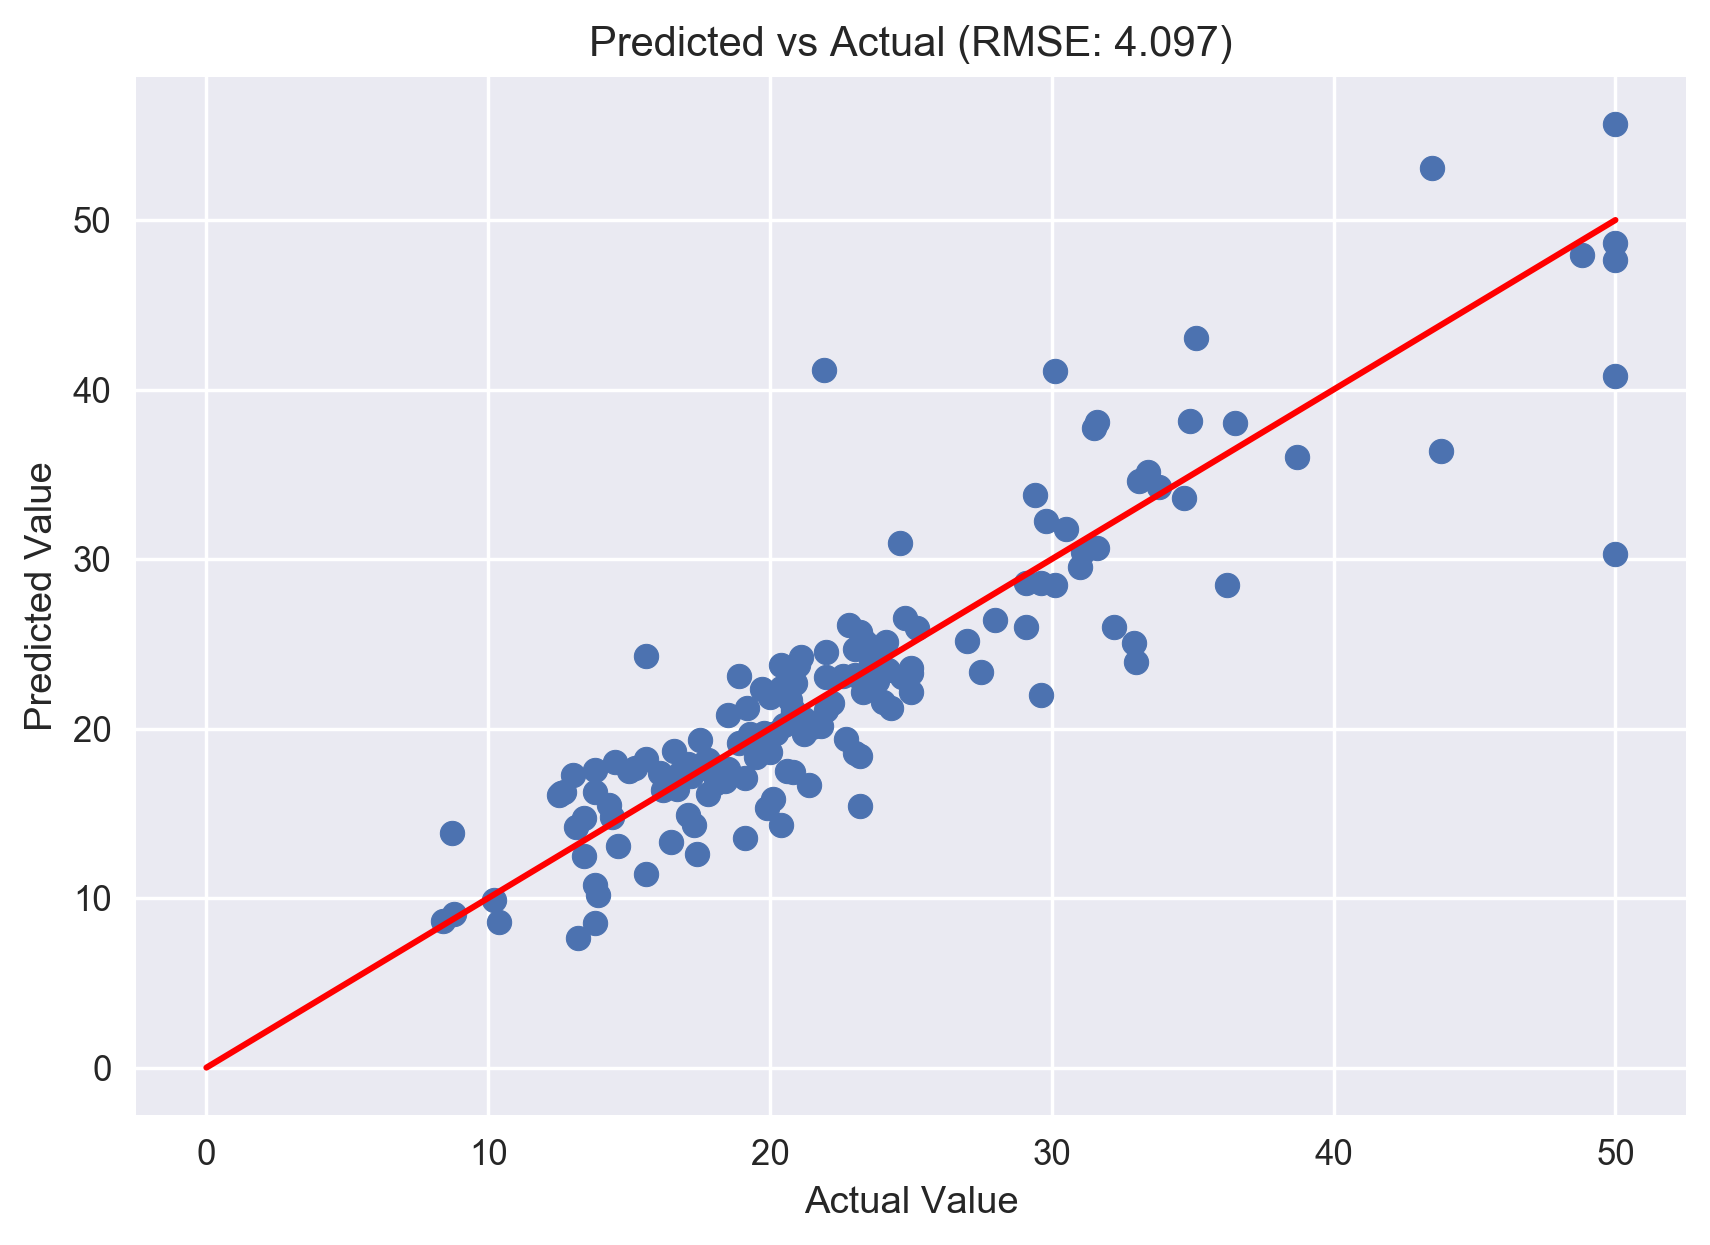

In [44]:
mlp = get_model(best_guess)
mlp.fit(X_train, y_train)
pred = mlp.predict(X_test)
plt.figure(dpi=250)
plt.scatter(y_test, pred)
plt.plot([0,max(y_test)],[0,max(y_test)],'r-')
plt.title("Predicted vs Actual (RMSE: %.03f)"%np.sqrt(np.mean((y_test - pred)**2)))
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value");

In [45]:
current_generation = create_generation(population=250, layer_max=15)
fitness_tracking2 = evolve_to_solve(current_generation, 200, 100, 25, 0.5, 3, 5, verbose=True)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_base.py:194: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2


[8, 6, 6, 13, 14, 'relu', 'lbfgs', 0.8117150912789866, 'invscaling', 0.24064142510778114, 424]


/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: overflow encountered in square


Generation 5: 186
Current Best Score:  21.9661816228
[10, 14, 11, 13, 4, 'identity', 'sgd', 0.3426585161518836, 'invscaling', 0.4626972660246313, 462]
Generation 10: 186
Current Best Score:  28.3464626171
[11, 7, 9, 14, 2, 'relu', 'lbfgs', 0.9818258297990385, 'invscaling', 0.46679362181677614, 137]
Generation 15: 186
Current Best Score:  20.1880193245
[14, 2, 11, 12, 12, 'relu', 'lbfgs', 0.17625251175176257, 'constant', 0.825266923515682, 250]
Generation 20: 186
Current Best Score:  21.2480520667
[14, 6, 10, 6, 12, 'relu', 'lbfgs', 0.34713799129017836, 'constant', 0.30069793184699894, 484]
Generation 25: 186
Current Best Score:  17.9424195305
[10, 14, 11, 2, 12, 'relu', 'lbfgs', 0.17625251175176257, 'invscaling', 0.825266923515682, 484]
Generation 30: 186
Current Best Score:  16.4105829049
[10, 14, 11, 2, 12, 'relu', 'lbfgs', 0.17625251175176257, 'invscaling', 0.825266923515682, 484]
Generation 35: 186
Current Best Score:  16.4105829049
[10, 14, 11, 2, 12, 'relu', 'lbfgs', 0.1762525117

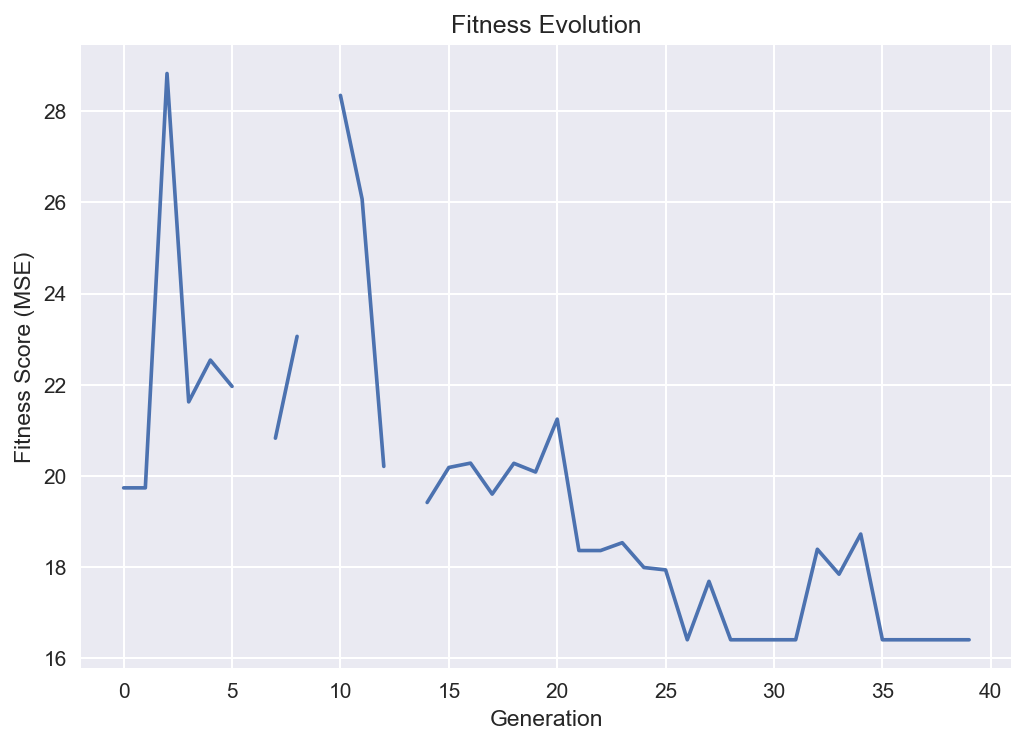

In [48]:
make_fitness_tracking_plot(fitness_tracking2[0])

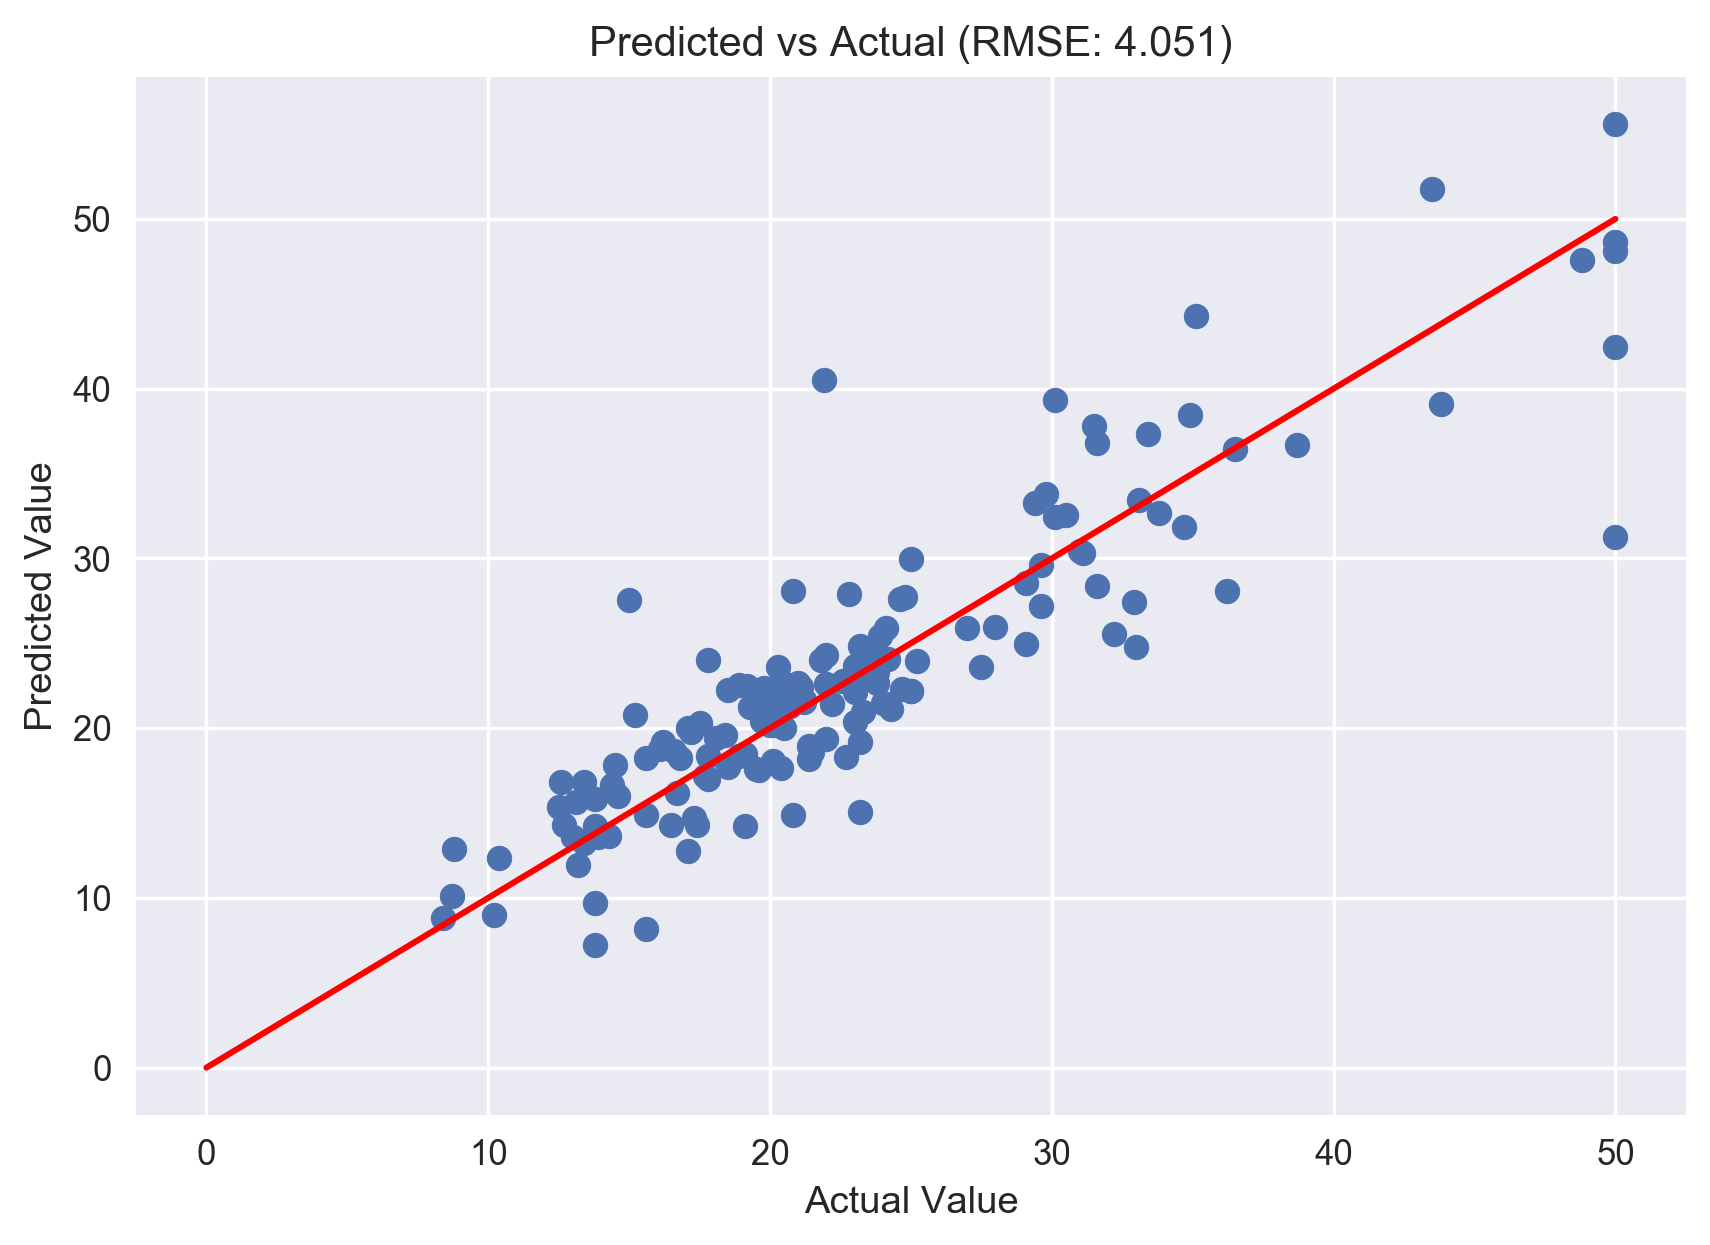

In [50]:
mlp = get_model(fitness_tracking2[1])
mlp.fit(X_train, y_train)
pred = mlp.predict(X_test)
plt.figure(dpi=250)
plt.scatter(y_test, pred)
plt.plot([0,max(y_test)],[0,max(y_test)],'r-')
plt.title("Predicted vs Actual (RMSE: %.03f)"%np.sqrt(np.mean((y_test - pred)**2)))
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value");